1. Model selection
2. Model finalization
3. Forecasting
4. Model update

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore") 

test RMSE: 7.259


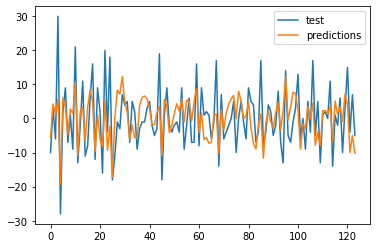

In [2]:
# model selection

def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return np.array(diff)

def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

df = pd.read_csv("data/daily-total-female-births.csv", header=0, index_col=0, parse_dates=True, squeeze=True)

X = difference(df.values)
train_size = int(len(X)*0.66)
train, test = X[0:train_size], X[train_size:]

model = AR(train)
model_fit = model.fit(maxlag=6, disp=False)
window = model_fit.k_ar
coef = model_fit.params

history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
    yhat = predict(coef, history)
    predictions.append(yhat)
    history.append(test[t])

rmse = np.sqrt(mean_squared_error(test, predictions))
print('test RMSE: %.3f' %rmse)

plt.plot(test, label='test')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

In [3]:
# finalize and save the model
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return np.array(diff)


df = pd.read_csv("data/daily-total-female-births.csv", header=0, index_col=0, parse_dates=True, squeeze=True)

X = difference(df.values)

model = AR(X)
model_fit = model.fit(maxlag=6, disp=False)
# save model
model_fit.save('ar_model.pkl')
# save differenced dataset
np.save('ar_data.npy', X)
# save last observation
np.save('ar_obs.npy', [df.values[-1]])

In [4]:
# load the model
from statsmodels.tsa.ar_model import ARResults
loaded = ARResults.load('ar_model.pkl')
print(loaded.params)
data = np.load('ar_data.npy')
last_obs = np.load('ar_obs.npy')
print(last_obs)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[50]


In [5]:
# manually saving
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return np.array(diff)


df = pd.read_csv("data/daily-total-female-births.csv", header=0, index_col=0, parse_dates=True, squeeze=True)

X = difference(df.values)

window_size = 6
model = AR(X)
model_fit = model.fit(maxlag=window_size, disp=False)

coef = model_fit.params
np.save('man_model.npy', coef)

lag = X[-window_size:]
np.save('man_lag.npy', lag)

np.save('man_obs.npy', [df.values[-1]])

In [6]:
coef = np.load('man_model.npy')
print(coef)
lag = np.load('man_lag.npy')
print(lag)
last_obs = np.load('man_obs.npy')
print(last_obs)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[-10   3  15  -4   7  -5]
[50]


In [7]:
# load and make one-step forecast

model = ARResults.load('ar_model.pkl')
data = np.load('ar_data.npy')
last_obs = np.load('ar_obs.npy')

predictions = model.predict(start=len(data), end=len(data))
# transform prediction
yhat = predictions[0] + last_obs[0]
print('Prediction: %f' %yhat)

Prediction: 46.755211


In [8]:
# load coef and make manual prediction
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

coef = np.load('man_model.npy')
lag = np.load('man_lag.npy')
last_obs = np.load('man_obs.npy')

prediction = predict(coef, lag)

yhat = prediction + last_obs[0]
print('Prediction: %f' %yhat)

Prediction: 46.755211


In [9]:
# update model with new obs

observation = 48

data = np.load('ar_data.npy')
last_obs = np.load('ar_obs.npy')

diffed = observation - last_obs[0]
data = np.append(data, [diffed], axis=0)
np.save('ar_data.npy', data)

last_obs[0] = observation
np.save('ar_obs.npy', last_obs)

In [10]:
# update model with new obs manual model

observation = 48

data = np.load('man_lag.npy')
last_obs = np.load('man_obs.npy')

diffed = observation - last_obs[0]
lag = np.append(lag[1:], [diffed], axis=0)
np.save('man_lag.npy', lag)

last_obs[0] = observation
np.save('man_obs.npy', last_obs)